In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import csv
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dask.dataframe as dd
import dask.array as da
from dask.diagnostics import ProgressBar

import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/asl-fingerspelling/supplemental_metadata.csv
/kaggle/input/asl-fingerspelling/character_to_prediction_index.json
/kaggle/input/asl-fingerspelling/train.csv
/kaggle/input/asl-fingerspelling/supplemental_landmarks/371169664.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/369584223.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1682915129.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/775880548.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2100073719.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1650637630.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1471096258.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/86446671.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/897287709.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/333606065.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2057261717.parquet
/kaggle/inpu

In [4]:
#By Rob Mulla https://www.kaggle.com/code/robikscube/sign-language-recognition-eda-twitch-stream

BASE_DIR = '../input/asl-fingerspelling/'
train = pd.read_csv(f'{BASE_DIR}/train.csv')

In [5]:
#By Rob Mulla https://www.kaggle.com/code/robikscube/sign-language-recognition-eda-twitch-stream

# Train.csv has the path to each parquet file, the particpant id, sequence_id and sign.
train.head()


,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


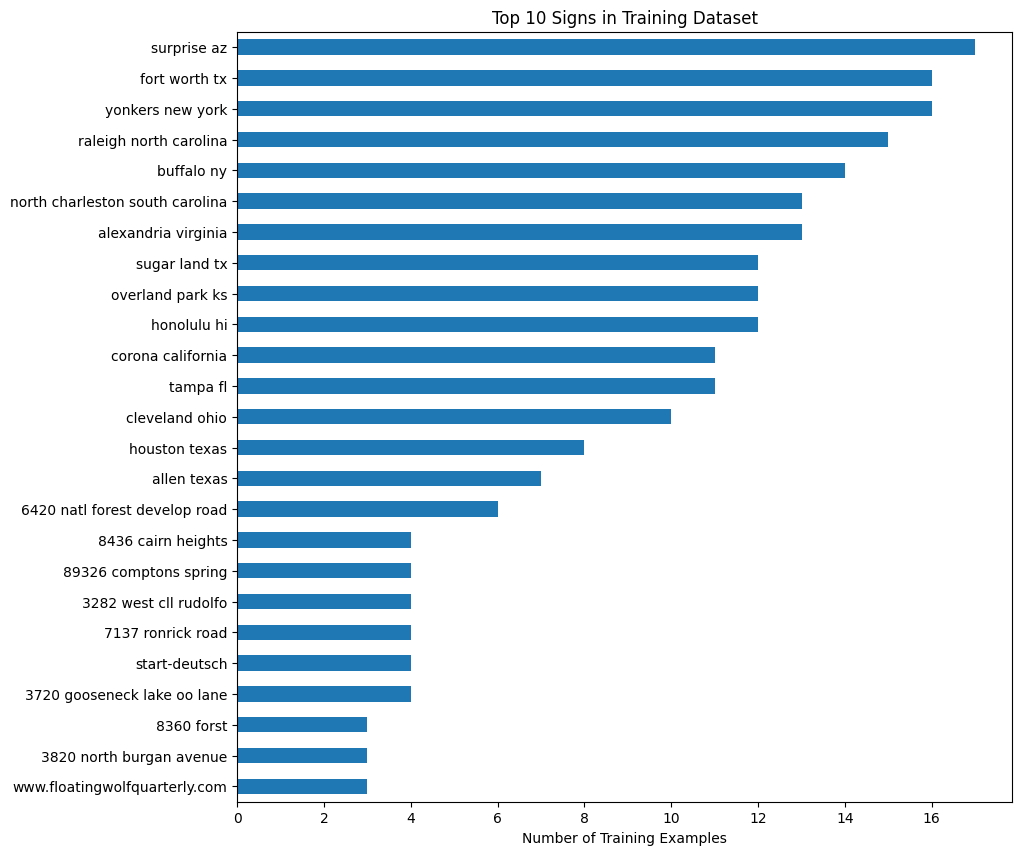

In [8]:
#Plotting the top 10 signs in the Kaggle dataset
fig, ax = plt.subplots(figsize=(10, 10))
train["phrase"].value_counts().head(25).sort_values(ascending=True).plot(
    kind="barh", ax=ax, title="Top 10 Signs in Training Dataset"
)
ax.set_xlabel("Number of Training Examples")
plt.show()

In [9]:
#Reading the metadata
df = pd.read_csv("/kaggle/input/asl-fingerspelling/supplemental_metadata.csv", delimiter=',', encoding='UTF-8')
pd.set_option('display.max_columns', None)
df.head(70)

,path,file_id,sequence_id,participant_id,phrase
0,supplemental_landmarks/33432165.parquet,33432165,1535467051,251,coming up with killer sound bites
1,supplemental_landmarks/33432165.parquet,33432165,1535499058,239,we better investigate this
2,supplemental_landmarks/33432165.parquet,33432165,1535530550,245,interesting observation was made
3,supplemental_landmarks/33432165.parquet,33432165,1535545499,38,victims deserve more redress
4,supplemental_landmarks/33432165.parquet,33432165,1535585216,254,knee bone is connected to the thigh bone
...,...,...,...,...,...
65,supplemental_landmarks/33432165.parquet,33432165,1538302225,54,i can still feel your presence
66,supplemental_landmarks/33432165.parquet,33432165,1538433677,47,only an idiot would lie in court
67,supplemental_landmarks/33432165.parquet,33432165,1538438874,241,the insulation is not working
68,supplemental_landmarks/33432165.parquet,33432165,1538474478,141,your etiquette needs some work


In [10]:
df["phrase"].value_counts()

why do you ask silly questions            117
find a nearby parking spot                117
apartments are too expensive              116
what to do when the oil runs dry          115
that agreement is rife with problems      115
                                         ... 
saving that child was an heroic effort     17
you will loose your voice                  16
everybody looses in custody battles        15
if at first you do not succees              1
my favorite place is to visit               1
Name: phrase, Length: 508, dtype: int64

In [11]:
silly = df[(df['phrase']=="why do you ask silly questions")].reset_index(drop=True)
silly.head()

,path,file_id,sequence_id,participant_id,phrase
0,supplemental_landmarks/86446671.parquet,86446671,756033602,221,why do you ask silly questions
1,supplemental_landmarks/95345213.parquet,95345213,1951872287,26,why do you ask silly questions
2,supplemental_landmarks/95345213.parquet,95345213,1973241762,216,why do you ask silly questions
3,supplemental_landmarks/131312512.parquet,131312512,987956375,136,why do you ask silly questions
4,supplemental_landmarks/193950599.parquet,193950599,720743796,107,why do you ask silly questions


In [12]:
example_fn = train.query('phrase == "scales/kuhaylah"')["path"].values[0]

example_landmark = pd.read_parquet(f"{BASE_DIR}/{example_fn}")
example_landmark.head()

frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1816796431       0  0.710588  0.699951  0.705657  0.691768  0.699669   
1816796431       1  0.709525  0.697582  0.703713  0.691016  0.697576   
1816796431       2  0.711059  0.700858  0.706272  0.693285  0.700825   
1816796431       3  0.712799  0.702518  0.707840  0.694899  0.702445   
1816796431       4  0.712349  0.705451  0.709918  0.696006  0.705180   

             x_face_5  x_face_6  x_face_7  x_face_8  x_face_9  x_face_10  \
sequence_id                                                                
1816796431   0.701980  0.709724  0.610405  0.712660  0.713004   0.716668   
1816796431   0.700467  0.709796  0.616540  0.713729  0.714435   0.719558   
1816796431   0.703319  0.711549  0.615606  0.715143  0.715867   0.720836   
1816796431   0.704794  0.712483  0.625044  0.715677  0.716231   0.720678   
1816796431   0.706928  0.712685  0.614356  0.714875  0.715110   0.717710   

             x_face_11  x_face_12  x_face_13  x_face_14  x_face_15  x_face_16  \
sequence_id                                                                     
1816796431    0.710871   0.711406   0.712219   0.711857   0.711868   0.712037   
1816796431    0.709844   0.710382   0.711181   0.710837   0.710657   0.710658   
1816796431    0.711340   0.711864   0.712644   0.712346   0.712275   0.712357   
1816796431    0.712962   0.713302   0.713885   0.713480   0.713300   0.713208   
1816796431    0.712470   0.712828   0.713431   0.712995   0.712710   0.712452   

             x_face_17  x_face_18  x_face_19  x_face_20  x_face_21  x_face_22  \
sequence_id                                                                     
1816796431    0.712642   0.710864   0.701962   0.690785   0.574435   0.652201   
1816796431    0.711053   0.706864   0.699644   0.688590   0.580494   0.655051   
1816796431    0.712808   0.709137   0.702700   0.691392   0.577924   0.654188   
1816796431    0.713368   0.709939   0.704363   0.693143   0.580396   0.663229   
1816796431    0.712426   0.711674   0.707145   0.695490   0.571968   0.655560   

             x_face_23  x_face_24  x_face_25  x_face_26  x_face_27  x_face_28  \
sequence_id                                                                     
1816796431    0.637868   0.623929   0.604830   0.664349   0.629179   0.645488   
1816796431    0.641654   0.628472   0.610501   0.666192   0.635521   0.650769   
1816796431    0.640510   0.627165   0.609320   0.665847   0.635727   0.650842   
1816796431    0.649336   0.635868   0.618672   0.674972   0.641881   0.657203   
1816796431    0.640964   0.626806   0.608233   0.667761   0.633646   0.650139   

             x_face_29  x_face_30  x_face_31  x_face_32  x_face_33  x_face_34  \
sequence_id                                                                     
1816796431    0.613881   0.604104   0.595274   0.655572   0.605329   0.567962   
1816796431    0.620963   0.611418   0.600352   0.652655   0.611691   0.572913   
1816796431    0.621108   0.611211   0.598542   0.653407   0.610695   0.569467   
1816796431    0.627606   0.618491   0.606223   0.655135   0.620123   0.572598   
1816796431    0.618022   0.607935   0.596722   0.656564   0.609164   0.566100   

             x_face_35  x_face_36  x_face_37  x_face_38  x_face_39  x_face_40  \
sequence_id                                                                     
1816796431    0.582004   0.635376   0.691068   0.694257   0.672491   0.659999   
1816796431    0.588026   0.635606   0.689966   0.693362   0.671613   0.659798   
1816796431    0.585980   0.636610   0.691479   0.694764   0.672846   0.660680   
1816796431    0.592384   0.639424   0.693746   0.696692   0.675276   0.663020   
1816796431    0.583412   0.638292   0.693101   0.695989   0.674172   0.661701   

             x_face_41  x_face_42  x_face_43  x_face_44  x_face_45  x_face_46  \
sequence_id                                           

In [13]:
#Calculating the unique frames from the dataset
unique_frames = example_landmark["frame"].nunique()
#unique_types = example_landmark["type"].nunique()
#types_in_video = example_landmark["type"].unique()
print(
    f"The file has {unique_frames} unique frames"
)

The file has 672 unique frames


In [15]:
ddf = dd.read_parquet("/kaggle/input/asl-fingerspelling/train_landmarks/1019715464.parquet")

In [16]:
%%time
len(ddf)

CPU times: user 329 ms, sys: 47.7 ms, total: 376 ms
Wall time: 569 ms


161461

In [17]:
ddf.head()

frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1975433633       0  0.578892  0.578482  0.582906  0.572686  0.579030   
1975433633       1  0.577563  0.578528  0.582916  0.572760  0.579090   
1975433633       2  0.576181  0.576949  0.581346  0.572293  0.577725   
1975433633       3  0.575575  0.577569  0.581769  0.572443  0.578289   
1975433633       4  0.577907  0.577628  0.582295  0.572930  0.578345   

             x_face_5  x_face_6  x_face_7  x_face_8  x_face_9  x_face_10  \
sequence_id                                                                
1975433633   0.582115  0.591430  0.498995  0.595773  0.596977   0.605065   
1975433633   0.582197  0.591687  0.497613  0.596104  0.597340   0.605690   
1975433633   0.581191  0.591550  0.497113  0.596477  0.598010   0.607338   
1975433633   0.581652  0.591728  0.496759  0.596573  0.598046   0.606920   
1975433633   0.581873  0.592467  0.498170  0.597383  0.598794   0.607799   

             x_face_11  x_face_12  x_face_13  x_face_14  x_face_15  x_face_16  \
sequence_id                                                                     
1975433633    0.578535   0.578844   0.579911   0.579761   0.578647   0.577652   
1975433633    0.577165   0.577554   0.578782   0.578465   0.577141   0.575957   
1975433633    0.575816   0.576288   0.577569   0.577347   0.575997   0.574820   
1975433633    0.575234   0.575716   0.577008   0.576686   0.575360   0.574225   
1975433633    0.577483   0.577828   0.578944   0.578837   0.577645   0.576605   

             x_face_17  x_face_18  x_face_19  x_face_20  x_face_21  x_face_22  \
sequence_id                                                                     
1975433633    0.577231   0.581995   0.579889   0.569285   0.456557   0.535281   
1975433633    0.575449   0.582145   0.579924   0.569081   0.456137   0.535068   
1975433633    0.574349   0.579356   0.578282   0.567548   0.460338   0.535383   
1975433633    0.573810   0.579847   0.578909   0.568321   0.457174   0.533959   
1975433633    0.576188   0.580676   0.579090   0.568772   0.459536   0.536419   

             x_face_23  x_face_24  x_face_25  x_face_26  x_face_27  x_face_28  \
sequence_id                                                                     
1975433633    0.521704   0.508697   0.492001   0.547073   0.517626   0.532683   
1975433633    0.521065   0.507715   0.490709   0.547155   0.516748   0.532349   
1975433633    0.520763   0.507119   0.490542   0.548084   0.516968   0.533271   
1975433633    0.519628   0.506225   0.489791   0.546503   0.516582   0.532326   
1975433633    0.521867   0.508184   0.491507   0.548999   0.517621   0.533883   

             x_face_29  x_face_30  x_face_31  x_face_32  x_face_33  x_face_34  \
sequence_id                                                                     
1975433633    0.503437   0.493949   0.479433   0.529043   0.494341   0.446412   
1975433633    0.502237   0.492571   0.478128   0.528776   0.492843   0.445855   
1975433633    0.501967   0.492155   0.478158   0.526743   0.492634   0.449903   
1975433633    0.502003   0.492327   0.476948   0.526722   0.492277   0.446594   
1975433633    0.502653   0.492901   0.478895   0.527559   0.493613   0.448979   

             x_face_35  x_face_36  x_face_37  x_face_38  x_face_39  x_face_40  \
sequence_id                                                                     
1975433633    0.465154   0.516167   0.562219   0.564374   0.546670   0.536328   
1975433633    0.463929   0.515785   0.560934   0.563204   0.545572   0.535534   
1975433633    0.465450   0.516551   0.559697   0.562379   0.544694   0.535137   
1975433633    0.463464   0.515456   0.559257   0.561863   0.544307   0.534622   
1975433633    0.465699   0.516475   0.561252   0.563531   0.545690   0.535596   

             x_face_41  x_face_42  x_face_43  x_face_44  x_face_45  x_face_46  \
sequence_id                                           

In [18]:
ddf.x_face_0.describe().compute()

count    160278.000000
mean          0.554182
std           0.129534
min           0.103906
25%           0.489872
50%           0.572730
75%           0.639833
max           1.022021
Name: x_face_0, dtype: float64

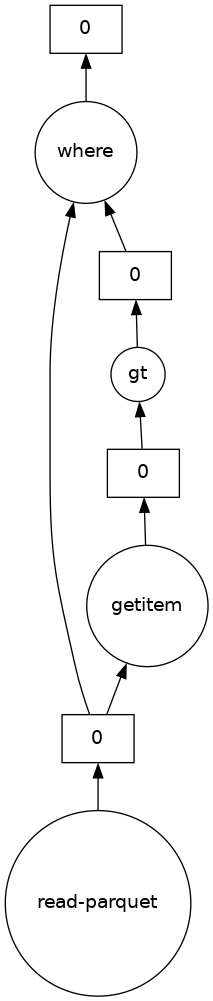

In [19]:
#https://www.kaggle.com/code/luxcem/dask-on-large-parquet-dataset/notebook

ddf.where(ddf.x_face_0 > 50).visualize()

In [23]:
#https://www.kaggle.com/code/luxcem/dask-on-large-parquet-dataset/notebook

h, bins = da.histogram(ddf[["x_face_0"]].to_dask_array(), bins=(0, 1, 2, 5, 10, 20, 50, 100, 1000))

In [24]:
with ProgressBar():
    hd = h.compute()
    bins = bins.compute()

[########################################] | 100% Completed | 12.29 ss
[########################################] | 100% Completed | 103.83 ms


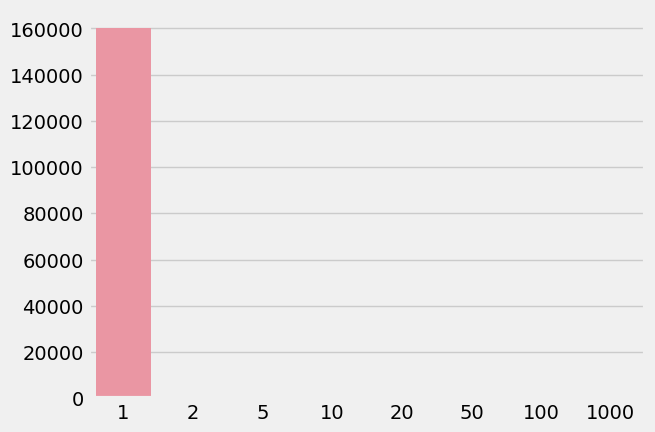

In [25]:
#https://www.kaggle.com/code/luxcem/dask-on-large-parquet-dataset/notebook

plt.style.use('fivethirtyeight')

sns.barplot(x=bins[1:], y=hd);

In [26]:
#By Sohier Dane https://www.kaggle.com/code/sohier/reading-the-data-with-python

import pyarrow.parquet as pq

train = pq.read_pandas('../input/asl-fingerspelling/train_landmarks/1019715464.parquet').to_pandas()

References:

Luxcem: https://www.kaggle.com/code/luxcem/dask-on-large-parquet-dataset/notebook

Rob Mulla https://www.kaggle.com/code/robikscube/sign-language-recognition-eda-twitch-stream

Sohier Dane https://www.kaggle.com/code/sohier/reading-the-data-with-python